### How many variants are there?

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict, OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/mp/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

In [3]:
from ipynb.fs.defs.F01_Library_diversity import convert_variant_to_dict

In [4]:
os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/code_check")

with open('mek.pickle', 'rb') as f:
    mek = pickle.load(f)

df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

In [5]:
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
splimlib = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

def is_variant_in_expected_set(m_by_pos, splimlib):
    for k, a in m_by_pos.items():
        if k not in splimlib.keys():
            return False
        elif a not in splimlib[k]:
            return False
        
    return True

In [6]:
def get_vars_by_count(gate, cutoff, correct_only):
    vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))

    for mutation_string, c in mek[gate].items():
        if correct_only:
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            if not is_variant_in_expected_set(m_by_pos, splimlib):
                continue
        if c >= cutoff:
            vars_by_count[cutoff] +=1
        else:
            vars_by_count[c] +=1
    
    return vars_by_count

def poisson_plot_for_choosing_cutoff(gate, cutoff, plot_title, colours = ['b', 'c'], filename=""):
    
    everything = get_vars_by_count(gate, cutoff, correct_only=False)
    expected = get_vars_by_count(gate, cutoff, correct_only=True)
    
    ind = np.arange(len(everything))  # the x locations for the groups
    width = 0.35       # the width of the bars
        
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind, everything.values(), width, color=colours[0])
    rects2 = ax.bar(ind + width, expected.values(), width, color=colours[1])

    # add some text for labels, title and axes ticks
    ax.set_title(plot_title, x=0.5, y=0.9)
    ax.set_ylabel('# of variants')
    ax.set_xlabel('Sequencing observation count')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(everything.keys())

    ax.legend((rects1[0], rects2[0]), ('All', 'Expected'))

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()
    
    
def poisson_plot_for_choosing_cutoff_zoomed(gate, cutoff, plot_title, sel_start = 0, colours = ['b', 'c'], filename=""):
    
    everything = get_vars_by_count(gate, cutoff, correct_only=False)
    expected = get_vars_by_count(gate, cutoff, correct_only=True)
    
    ind = np.arange(len(everything))  # the x locations for the groups
    width = 0.35       # the width of the bars
        
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind[sel_start:-1], list(everything.values())[sel_start:-1], width, color=colours[0])
    rects2 = ax.bar(ind[sel_start:-1] + width, list(expected.values())[sel_start:-1], width, color=colours[1])

    # add some text for labels, title and axes ticks
    ax.set_title(plot_title, x=0.5, y=0.9)
    ax.set_ylabel('# of variants')
    ax.set_xlabel('Sequencing observation count')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(everything.keys())

    ax.legend((rects1[0], rects2[0]), ('All', 'Expected'))

    plt.tight_layout()
    #if filename:
    #    plt.savefig(filename)
    plt.show()

### Examine number of variants detected in each gate as a function of the read count

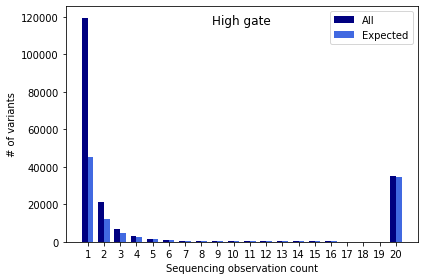

In [7]:
poisson_plot_for_choosing_cutoff('high', 20, 'High gate', colours=['navy', 'royalblue'], filename='Seq_cutoffs_high.png')

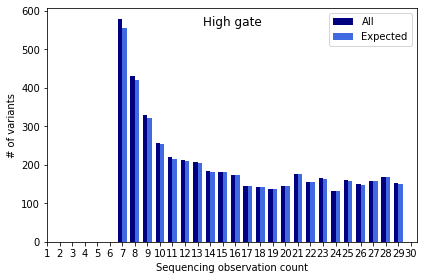

In [8]:
poisson_plot_for_choosing_cutoff_zoomed('high', 30, 'High gate', sel_start = 6, colours=['navy', 'royalblue'], filename='Seq_cutoffs_high_zoom.png')

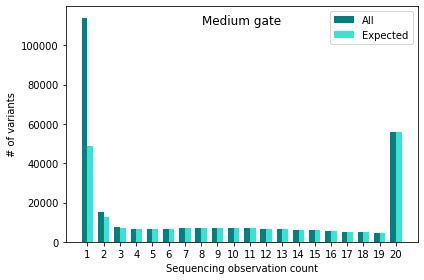

In [9]:
poisson_plot_for_choosing_cutoff('med', 20, 'Medium gate', colours=['teal', 'turquoise'], filename= 'Seq_cutoffs_medium.png')

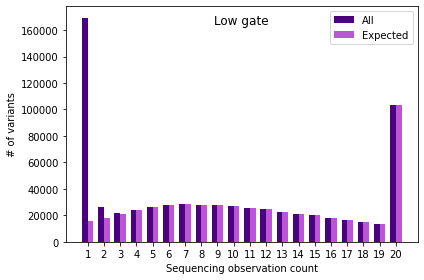

In [10]:
poisson_plot_for_choosing_cutoff('low-t', 20, 'Low gate', colours=['indigo', 'mediumorchid'], filename='Seq_cutoffs_low.png')

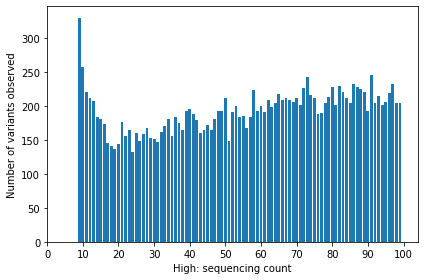

In [11]:
cutoff = 100
vars_by_count = OrderedDict((i, 0) for i in range(1, cutoff +1))
for c in mek['high'].values():
    if c >= cutoff:
        vars_by_count[cutoff] +=1
    else:
        vars_by_count[c] +=1

plt.bar(list(vars_by_count.keys())[8:-1], list(vars_by_count.values())[8:-1])
plt.xticks(np.arange(0, cutoff+1, 10))
plt.xlabel('High: sequencing count')
plt.ylabel('Number of variants observed')
plt.tight_layout()
#plt.savefig('Seq_cutoffs_high_2.png')
plt.show()